In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import timedelta
import os
from constants import *
from trip_file import TripFile
from trip import Trip
from tqdm import tqdm
import seaborn as sns


In [3]:
taarif = pd.read_csv("../files/taarif.csv")
taarif = taarif.drop(0).reset_index().drop(columns=["index"]) # first row is nulls
new_drivers = pd.read_csv("../files/new_drivers.csv", index_col=0)
drivers_with_kviut = pd.read_csv("../files/drivers_with_kviut.csv",index_col=0)

In [4]:
def preprocess_drivers(drivers: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = drivers
    if copy:
        df = drivers.copy()

    gender_mapping = {"F": FEMALE,
                    "M":MALE,
                    "m":MALE,
                    "male":MALE,
                    "boy":MALE,
                    "unknown":UNKOWN,
                    'woman':FEMALE,
                    'girl':FEMALE,
                    'none':UNKOWN,
                    'female':FEMALE,
                    UNKOWN:UNKOWN}

    # Make preprocess
    df.gender = df.gender.fillna(UNKOWN)
    df.gender = df.gender.apply(lambda x: gender_mapping[x])
    df.birthdate = pd.to_datetime(df.birthdate, format="mixed")
    drivers.birthdate = drivers.birthdate.fillna(datetime.datetime.now())

    return df

def preprocess_taarif(taarif_df: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = taarif_df
    if copy:
        df = new_drivers.copy()

    customers_mapping = {
            "dbs" : "yes",
            "mizranei_kfar_saba": "aminach",
            "telecommunication_ltd": "hot" 
    }

    for customer, new_customer in customers_mapping.items():
        # Select the row to duplicate (let's say the first row, index 0)
        row_to_duplicate = df[df["customer"] == customer]
        # Make a copy of the row
        new_row = row_to_duplicate.copy()
        new_row["customer"] = new_customer
        # Append the modified row to the DataFrame
        df = pd.concat([df,pd.DataFrame(new_row)], ignore_index=True)
        
    return df


# Concat the two tables of drivers with and without kviut
def concat_drivers_tables(new_drivers, drivers_with_kviut):
    drivers_with_kviut["kviut"] = 1
    drivers = pd.concat([new_drivers, drivers_with_kviut])
    drivers["kviut"] = drivers["kviut"].fillna(0)
    return drivers
    

In [5]:
drivers = concat_drivers_tables(new_drivers, drivers_with_kviut)
drivers = preprocess_drivers(drivers, copy=True)
taarif = preprocess_taarif(taarif)

In [6]:
def get_trip_files(folder, limit=100):
    files = np.array(list(os.listdir(folder)))
    if limit:
        files = files[:limit]
    files = np.array([name if not name[-5] == ")" else name[:-7]+".csv" for name in files])
    print("Processing files....")
    return np.array([TripFile(os.path.join(folder,file)) for file in tqdm(files)])


In [7]:
trip_files = get_trip_files("../files/trips_data", limit=None)

Processing files....


 16%|█▋        | 996/6111 [00:16<01:12, 70.12it/s] c:\Users\Ron Tohar\Desktop\הכשרה\CV_training\basic\python\Basic - Azrieli & Sons data\project_files\trip_file.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trips_df.end_time = pd.to_datetime(trips_df.end_time)
100%|██████████| 6111/6111 [01:35<00:00, 63.79it/s]


In [8]:
all_dfs = [trip_file.get_data_frame() for trip_file in trip_files ]
trips_df = pd.concat(all_dfs)
trips_df.end_time = pd.to_datetime(trips_df["end_time"])
trips_df.start_time = pd.to_datetime(trips_df["start_time"])


### Observe trips hours


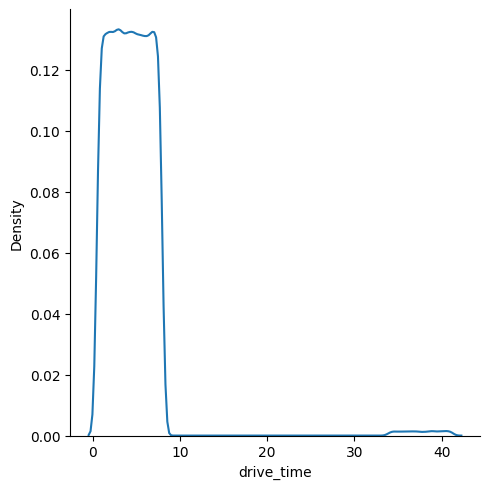

In [32]:
# sns.histplot(x=)
trips_df["drive_time"] = (trips_df["end_time"]-trips_df["start_time"]) / timedelta(hours=1)
trips_df = trips_df.reset_index().drop(columns=["index"])

sns.displot(x="drive_time", data=trips_df, kind="kde")
# trips_df


#### What are the trips that take more then 10 hours?

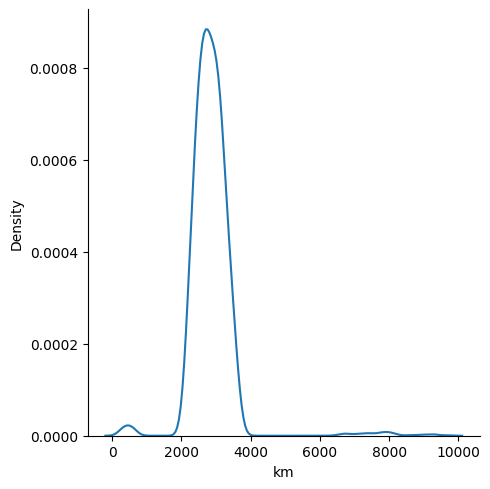

In [39]:
long_drives = trips_df[trips_df["drive_time"] >15]
sns.displot(x="km", data=long_drives, kind="kde")
# sns.displot(x="km", data=trips_df, kind="kde")

<Axes: xlabel='drive_time', ylabel='km'>

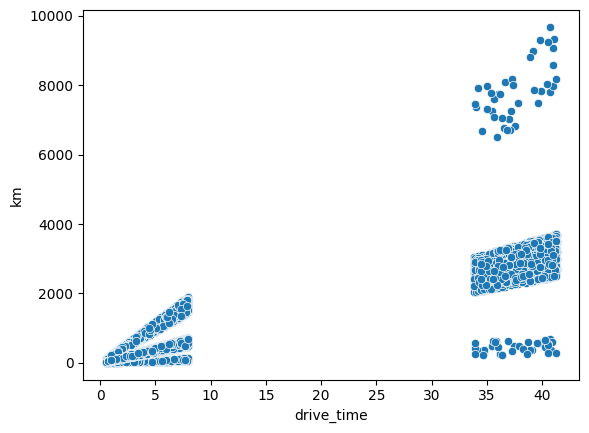

In [41]:
sns.scatterplot(x="drive_time", y="km", data=trips_df)
# sns.displot(x="drive_time", y="km", data=trips_df[trips_df["drive_time"]<15])

In [12]:
df1 = trips_df[trips_df["start_time"].dt.date == pd.to_datetime("2015-04-01").date()]
diffs=  ((df1["end_time"] - df1["start_time"]) / timedelta(hours=1))
kph = df1["km"] / ((df1["end_time"] - df1["start_time"]) / timedelta(hours=1))
df1["kph"] = kph
df1["diff"] = diffs
df1

C:\Users\Ron Tohar\AppData\Local\Temp\ipykernel_3428\2740097359.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["kph"] = kph
C:\Users\Ron Tohar\AppData\Local\Temp\ipykernel_3428\2740097359.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["diff"] = diffs


,customer,driver_id,end_time,km,start_time,trips_hours,kph,diff
0,iaf,570,2015-04-01 09:36:00,672.312716,2015-04-01 01:55:00,7.683333,87.502740,7.683333
1,yes,822,2015-04-01 16:17:00,96.048221,2015-04-01 15:12:00,1.083333,88.659896,1.083333
0,yes,145,2015-04-01 07:11:00,500.332355,2015-04-01 01:35:00,5.600000,89.345063,5.600000
1,aminach,124,2015-04-01 15:31:00,64.362047,2015-04-01 14:45:00,0.766667,83.950496,0.766667
0,yes,443,2015-04-01 03:26:00,42.505700,2015-04-01 02:53:00,0.550000,77.283090,0.550000
...,...,...,...,...,...,...,...,...
1,intel,151,2015-04-01 18:24:00,478.712578,2015-04-01 12:24:00,6.000000,79.785430,6.000000
0,angel,603,2015-04-01 04:55:00,143.683914,2015-04-01 02:36:00,2.316667,62.021833,2.316667
1,osem,578,2015-04-01 20:30:00,391.478456,2015-04-01 15:15:00,5.250000,74.567325,5.250000
0,iaf,840,2015-04-01 08:15:00,604.094143,2015-04-01 01:19:00,6.933333,87.128963,6.933333


ValueError: cannot reindex on an axis with duplicate labels

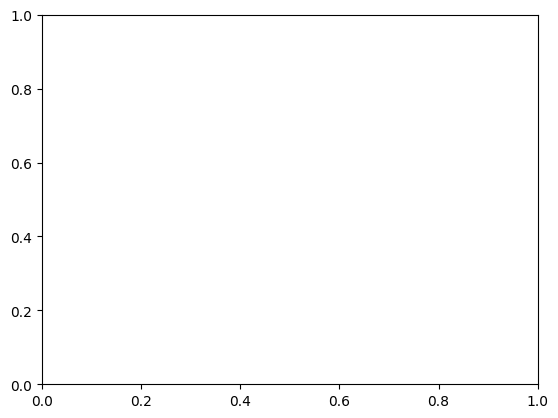

In [13]:
sns.lineplot(x=df1["start_time"].dt.time, y="kph", data=df1)
# df1["start_time"].dt.time